<a href="https://colab.research.google.com/github/DavydovichYana/Stats_hypothesis_check/blob/main/Titanic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель этого ноутбука: 

1.   выдвинуть несколько гипотез о пассажирах Титаника ❗
2.   проверить гипотезы статистическими методами ❗
3.   сделать выводы ❗

Будем считать, что с данными мы уже знакомы, поэтому сосредоточимся на гипотезах.

In [69]:
# Importing the dataset

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

plt.style.use('ggplot')
plt.rc('patch', edgecolor='black')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})

In [70]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **1-я гипотеза**
Проверим, различается ли статистически значимо цена билетов, которые покупали женщины и мужчины. 

In [71]:
data_f = data[data.Sex == 'female']
data_m = data[data.Sex == 'male']

In [72]:
print(data_f.shape, data_m.shape)

(314, 12) (577, 12)


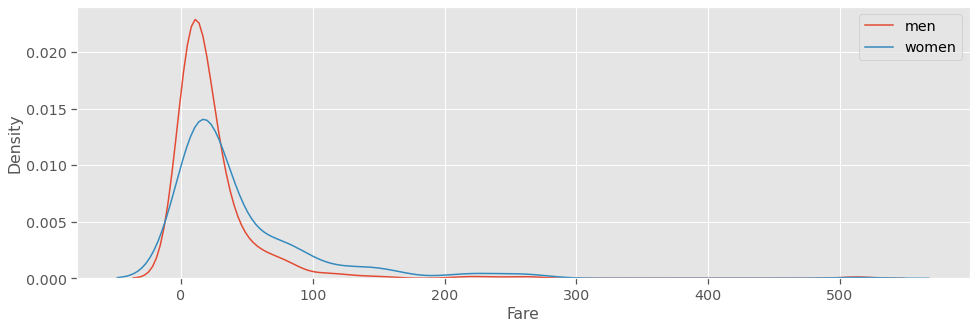

In [73]:
plt.figure(figsize=(16,5))

sns.kdeplot(data_m.Fare)
sns.kdeplot(data_f.Fare)

plt.legend(['men','women'])

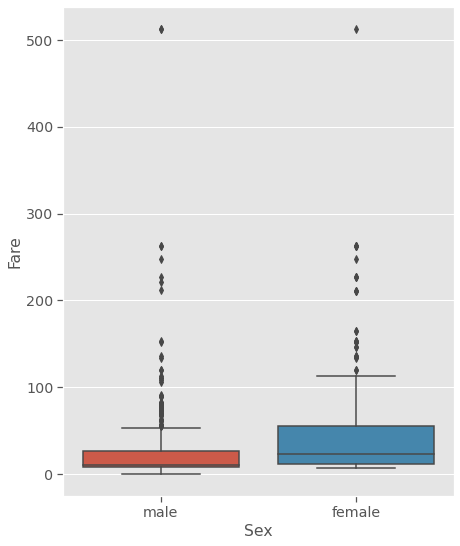

In [74]:
plt.figure(figsize=(7,9))

sns.boxplot('Sex', 'Fare', data=data)

In [75]:
from scipy.stats import shapiro

print(shapiro(data_f.Fare),shapiro(data_m.Fare))

(0.6361145973205566, 2.580287846596769e-25) (0.43366360664367676, 5.159334317114255e-39)


Итак,


1.   женщины платили за билет больше мужчин, исходя из графика ядерной оценки плотности (особое внимание на цену > 50) и боксплотов
2.   оба распределения ненормальные. Они имеют длинные хвосты справа (частое явление для данных о деньгах)

Так как у нас достаточно большое количество данных, несмотря на ненормальность распределений, мы можем применить t-test. Сравним его результаты с тестом Манна-Уитни



In [76]:
mannwhitneyu(data_f.Fare, data_m.Fare)

MannwhitneyuResult(statistic=62175.0, pvalue=4.806163481454681e-15)

In [77]:
ttest_ind(data_f.Fare, data_m.Fare)

Ttest_indResult(statistic=5.529140269385719, pvalue=4.2308678700429995e-08)

In [78]:
# Функция для бутстрапа взята отсюда: https://www.youtube.com/watch?v=-zps6hm0nX8&t=3007s

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

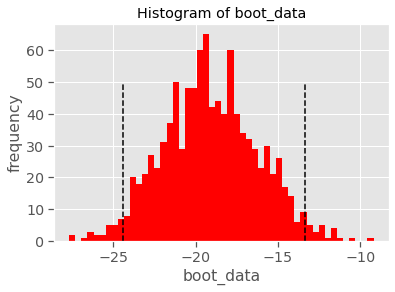

{'p_value': 2.963163318545689e-11, 'quants':                0
 0.025 -24.428817
 0.975 -13.348729}

In [79]:
get_bootstrap(
    data_m.Fare, data_f.Fare,
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Таким образом, цена билетов у женщин статистически значимо больше, чем у мужчин. Т.е. они ехали в более дорогих классах и имели больший шанс спастись не только из-за своего пола, но и из-за класса.

In [80]:
from IPython.core.display import HTML

def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [81]:
t1 = data.groupby(['Sex', 'Pclass'], as_index=False).agg({'Fare':'mean'}).style.background_gradient(vmin=0)
t2 = data.groupby(['Sex', 'Pclass'], as_index=False).agg({'Fare':'std'}).style.background_gradient(vmin=0)
t3 = data.groupby(['Sex', 'Pclass'], as_index=False).agg({'Fare':'median'}).style.background_gradient(vmin=0)
t4 = pd.pivot_table(data, 'Fare',['Pclass','Sex'],aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)
t5 = pd.crosstab([data.Sex,data.Pclass],data.Survived.round(3)*100,margins = True).style.background_gradient(vmin=0)

multi_table([t1, t2, t3,t4, t5])

,Sex,Pclass,Fare
0,female,1,106.125798
1,female,2,21.970121
2,female,3,16.118810
3,male,1,67.226127
4,male,2,19.741782
5,male,3,12.661633
,Sex,Pclass,Fare
0,female,1,74.259988
1,female,2,10.891796
2,female,3,11.690314


# 2-я гипотеза

Более молодые люди покупали более дешевые билеты.

In [82]:
data_age = data[data.Age.notna()]

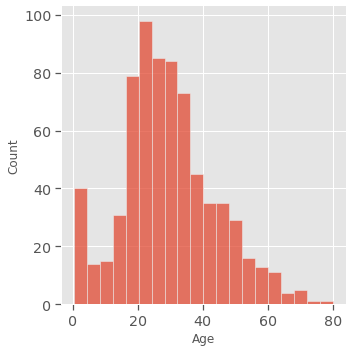

In [83]:
sns.displot(data_age.Age)

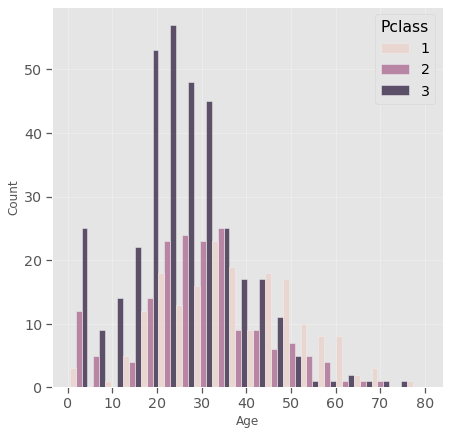

In [84]:
plt.figure(figsize = (7,7))
plt.grid(alpha = 0.3)
sns.histplot(data_age,x = 'Age',multiple='dodge',hue = 'Pclass')

In [85]:
data_age.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [86]:
from scipy.stats import pearsonr

cor_age_fare = pearsonr(data_age.Age, data_age.Fare)
cor_age_fare

(0.0960666917690389, 0.010216277504442105)

Возраст и цена билета не коррелируют между собой.

In [87]:
data_age['CategoricalAge'] = pd.qcut(data_age['Age'], 5, precision=0)

In [88]:
data_age.groupby('CategoricalAge', as_index=False).Fare.count()

,CategoricalAge,Fare
0,"(-1.0, 19.0]",164
1,"(19.0, 25.0]",137
2,"(25.0, 32.0]",127
3,"(32.0, 41.0]",144
4,"(41.0, 80.0]",142


In [89]:
pd.pivot_table(data_age, 'Fare','CategoricalAge',aggfunc=['count', 'median', 'mean']).style.background_gradient(vmin=0)

,count,median,mean
,Fare,Fare,Fare
CategoricalAge,,,
"(-1.0, 19.0]",164,19.258300,31.794741
"(19.0, 25.0]",137,9.225000,29.347809
"(25.0, 32.0]",127,13.000000,25.702458
"(32.0, 41.0]",144,19.856250,43.050865
"(41.0, 80.0]",142,26.550000,42.770132


In [90]:
# def rightValue(interval):
#   return interval.right

# data_age['CategoricalAge'] = data_age['CategoricalAge'].apply(rightValue)

In [91]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# data_age['CategoricalAge']=encoder.fit_transform(data_age['CategoricalAge'])

In [92]:
data_age.Fare.describe()

count    714.000000
mean      34.694514
std       52.918930
min        0.000000
25%        8.050000
50%       15.741700
75%       33.375000
max      512.329200
Name: Fare, dtype: float64

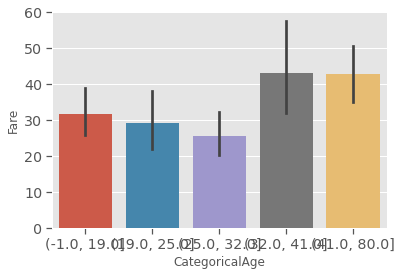

In [93]:
sns.barplot(x='CategoricalAge',y='Fare',data = data_age)

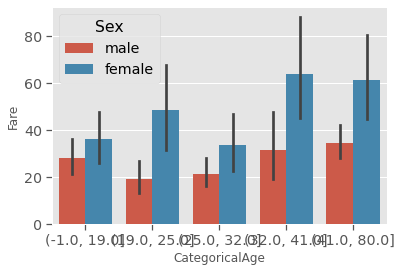

In [94]:
sns.barplot(x='CategoricalAge',y='Fare', hue = 'Sex',data = data_age)

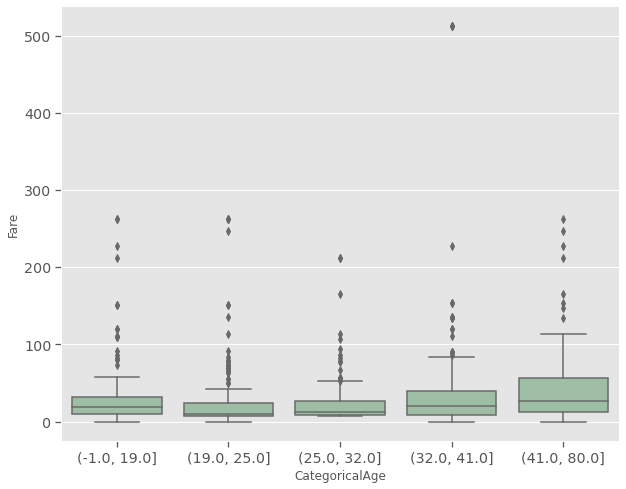

In [95]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='CategoricalAge', y='Fare', data=data_age, color='#99c2a2')
plt.show()

# 1. f_oneway из scipy.stats
(проведем дисперисионный анализ 3-мя разными способами)

In [96]:
from scipy.stats import f_oneway

d1 = data_age.query('CategoricalAge == (-1.0, 19.0)').Fare
d2 = data_age.query('CategoricalAge == (19.0, 25.0)').Fare 
d3 = data_age.query('CategoricalAge == (25.0, 32.0)').Fare
d4 = data_age.query('CategoricalAge == (32.0, 41.0)').Fare
d5 = data_age.query('CategoricalAge == (41.0, 80.0)').Fare

In [97]:
f_oneway(d1,d2,d3,d4,d5)

F_onewayResult(statistic=3.3304628322336827, pvalue=0.010058019175536387)

# 2. ols из  statsmodels.formula.api

In [98]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('Fare ~ C(CategoricalAge)', data=data_age).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(CategoricalAge),3.488026e+04,4.0,3.151433,0.01392
Residual,1.961814e+06,709.0,NaN,NaN


# 3. anova_test из bioinfokit.analys.stat

In [99]:
!pip install bioinfokit
from bioinfokit.analys import stat

In [100]:
res = stat()
res.anova_stat(df=data_age, res_var='Fare', xfac_var='CategoricalAge', anova_model='Fare ~ C(CategoricalAge)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(CategoricalAge),4.0,3.488026e+04,8720.064727,3.151433,0.01392
Residual,709.0,1.961814e+06,2767.015911,NaN,NaN


# 4. p-value < 0.05. 
Можно предложить, что стат. значимые различия между группами есть. Проведем post-hoc тест Тьюки, чтобы посмотреть между какими конкретными группами существуют значимые различия. Сделаем это 2 способами.

In [101]:
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res.tukey_hsd(df=data_age, res_var='Fare', xfac_var='CategoricalAge', anova_model='Fare ~ C(CategoricalAge)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(32.0, 41.0]","(41.0, 80.0]",22.852487,-17.934115,63.639089,2.183793,0.530500
1,"(32.0, 41.0]","(-1.0, 19.0]",2.880504,-47.043698,52.804706,0.224881,0.900000
2,"(32.0, 41.0]","(25.0, 32.0]",19.714992,-34.825660,74.255644,1.408873,0.839620
3,"(32.0, 41.0]","(19.0, 25.0]",9.996410,-43.741999,63.734819,0.725028,0.900000
4,"(41.0, 80.0]","(-1.0, 19.0]",25.732991,-21.197275,72.663257,2.137139,0.549112
5,"(41.0, 80.0]","(25.0, 32.0]",3.137495,-48.676660,54.951650,0.236010,0.900000
6,"(41.0, 80.0]","(19.0, 25.0]",32.848897,-18.120119,83.817912,2.511944,0.391980
7,"(-1.0, 19.0]","(25.0, 32.0]",22.595496,-36.680010,81.871003,1.485737,0.808956
8,"(-1.0, 19.0]","(19.0, 25.0]",7.115906,-51.422283,65.654094,0.473791,0.900000
9,"(25.0, 32.0]","(19.0, 25.0]",29.711402,-32.810405,92.233209,1.852197,0.662776


In [102]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

p1_tukey_test = pairwise_tukeyhsd(data_age.Fare,data_age.CategoricalAge)
print("\n\n" + str(p1_tukey_test._results_table))



       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
(-1.0, 19.0] (19.0, 25.0]  -2.4469    0.9 -19.0977 14.2039  False
(-1.0, 19.0] (25.0, 32.0]  -6.0923 0.8492 -23.0965 10.9119  False
(-1.0, 19.0] (32.0, 41.0]  11.2561 0.3325  -5.1727 27.6849  False
(-1.0, 19.0] (41.0, 80.0]  10.9754 0.3633  -5.5149 27.4657  False
(19.0, 25.0] (25.0, 32.0]  -3.6454    0.9 -21.3658 14.0751  False
(19.0, 25.0] (32.0, 41.0]  13.7031 0.1873   -3.466 30.8721  False
(19.0, 25.0] (41.0, 80.0]  13.4223 0.2082  -3.8056 30.6502  False
(25.0, 32.0] (32.0, 41.0]  17.3484 0.0536  -0.1636 34.8604  False
(25.0, 32.0] (41.0, 80.0]  17.0677 0.0617   -0.502 34.6374  False
(32.0, 41.0] (41.0, 80.0]  -0.2807    0.9 -17.2942 16.7327  False
-----------------------------------------------------------------


Как видно, стат. значимых различий между отдельными группами нет. Отвергаем гипотезу о существовании стат. значимых различий в цене билетов, купленных людьми разного возраста.